# **Step 1: Setup**

### **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Install Necessary Packages**

In [3]:
!apt-get install -y p7zip-full
!pip install gdown pymupdf
!pip install torch torchvision
!pip install easyocr
!pip install pytorch_lightning
!pip install wget

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 50.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f8611acce0b6e3881675b347f45a2840576762d6f3ce701e31d9c514b1f84dea
  Stored in directory: /root/.cache/p

### **Download the Data**

In [4]:
file_id = '15S3oofggnb3RfQWmJ2yTsuThFY6npskz'
!gdown --id $file_id -O /content/file.tar.7z

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15S3oofggnb3RfQWmJ2yTsuThFY6npskz
To: /content/file.tar.7z
100% 46.3M/46.3M [00:03<00:00, 13.6MB/s]


### **Extract the .7z Archive**

In [5]:
!7z e /content/file.tar.7z -o/content


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 46303949 bytes (45 MiB)

Extracting archive: /content/file.tar.7z
--
Path = /content/file.tar.7z
Type = 7z
Physical Size = 46303949
Headers Size = 166
Method = LZMA:24
Solid = -
Blocks = 1

  0%      6%     12% - real_Image_dataset_Detection.tar                                        19% - real_Image_dataset_Detection.tar                                        25% - real_Image_dataset_Detection.tar                                       

### **Extract the .tar File**

In [6]:
import tarfile

# Define the path for the .tar file and extraction
tar_path = '/content/real_Image_dataset_Detection.tar'
extract_path = '/content/real_Image_dataset_Detection'

# Extract files from the .tar archive
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)

print(f'Files extracted to {extract_path}')

Files extracted to /content/real_Image_dataset_Detection


### **Imports**

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import random
import os
import torch
from PIL import Image
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import easyocr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches


try:
  import pytorch_lightning as pl
except:
  !pip install --quiet pytorch-lightning>=1.5
  import pytorch_lightning as pl

# **Step 2: Text Detection**

### **Dataset Preparation - Convert Annotations for Faster R-CNN**

In [8]:
# Define custom dataset class for Faster R-CNN
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.txt'))

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse annotations
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                splits = line.strip().split(',')
                if len(splits) != 9:
                    continue
                x1, x2, x3, x4, y1, y2, y3, y4, lang = splits
                x_coords = [float(x1), float(x2), float(x3), float(x4)]
                y_coords = [float(y1), float(y2), float(y3), float(y4)]

                # Get min/max for bounding box
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                boxes.append([x_min, y_min, x_max, y_max])

                # Map language label to a class ID
                if "Hindi" in lang:
                    labels.append(1)
                elif "English" in lang:
                    labels.append(2)
                else:
                    labels.append(3)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

# Initialize the dataset
image_folder = '/content/real_Image_dataset_Detection/real_Image_dataset_Detection/Image'
label_folder = '/content/real_Image_dataset_Detection/real_Image_dataset_Detection/Annotation'
dataset = TextDataset(image_dir=image_folder, label_dir=label_folder)


### **Set Up the Faster R-CNN Model Without Pretraining**

In [9]:
# Load the Faster R-CNN model without pretrained weights
model = fasterrcnn_resnet50_fpn(pretrained=False)

# Modify the model for your custom classes (text classes + background)
num_classes = 4  # Adjust based on your label count (3 classes + background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to the appropriate device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### **Define DataLoader and Optimizer**

In [10]:
# DataLoader for training
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 40  # Increase epochs for training from scratch

### **Training Loop**

In [11]:
# Define the transform to convert PIL images to tensors
transform = T.ToTensor()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        # Convert images to tensors and move them to the device
        images = [transform(img).to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(data_loader)}")

Epoch 1/40, Loss: 0.7777290224471939
Epoch 2/40, Loss: 0.637020284884444
Epoch 3/40, Loss: 0.5947772244983744
Epoch 4/40, Loss: 0.5031491299377424
Epoch 5/40, Loss: 0.44628695266269075
Epoch 6/40, Loss: 0.39017922633162166
Epoch 7/40, Loss: 0.35479045290256217
Epoch 8/40, Loss: 0.3311558851850367
Epoch 9/40, Loss: 0.3134431193504378
Epoch 10/40, Loss: 0.28713568279119295
Epoch 11/40, Loss: 0.28411792065495645
Epoch 12/40, Loss: 0.2671709244496354
Epoch 13/40, Loss: 0.24073256900377363
Epoch 14/40, Loss: 0.22730682080037126
Epoch 15/40, Loss: 0.22242517483847163
Epoch 16/40, Loss: 0.2114608808655605
Epoch 17/40, Loss: 0.19212897302948426
Epoch 18/40, Loss: 0.1890640498321747
Epoch 19/40, Loss: 0.19570339164722747
Epoch 20/40, Loss: 0.17811252448324846
Epoch 21/40, Loss: 0.17618749812941684
Epoch 22/40, Loss: 0.1708675421704756
Epoch 23/40, Loss: 0.16271524361082326
Epoch 24/40, Loss: 0.16206454938260195
Epoch 25/40, Loss: 0.16129479379715206
Epoch 26/40, Loss: 0.14884702903088007
Epoch 

### **Inference and Visualization**

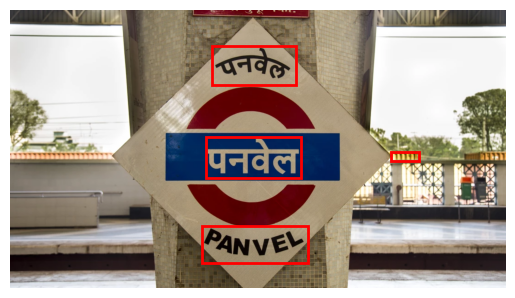

In [58]:
# Load a test image
# test_image = Image.open("/content/real_Image_dataset_Detection/real_Image_dataset_Detection/Image/141.jpg").convert("RGB")
test_image = Image.open("/content/pan.jpg").convert("RGB")
img_tensor = transform(test_image).unsqueeze(0).to(device)

# Inference
model.eval()
with torch.no_grad():
    prediction = model(img_tensor)

# Visualize results
fig, ax = plt.subplots(1)
ax.imshow(test_image)

for box, label in zip(prediction[0]['boxes'].cpu(), prediction[0]['labels'].cpu()):
    x_min, y_min, x_max, y_max = box
    width, height = x_max - x_min, y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis("off")
plt.show()


# **Step 3: Extraction**

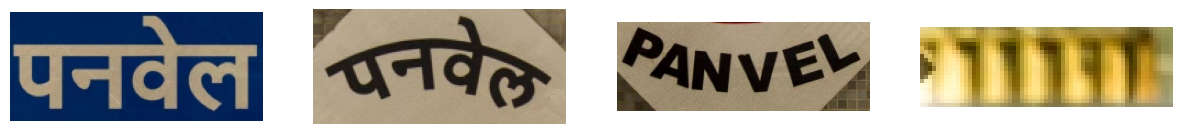

Extracted Hindi Text: ['पनवेल', 'चनवेल', 'PANVEk', '']


In [65]:
# Initialize the EasyOCR reader for Hindi and English languages
reader = easyocr.Reader(['hi', 'en'])

def crop_and_extract_hindi_text_with_easyocr(image, predictions):
    extracted_texts = []
    cropped_images = []

    # Extract boxes and labels
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    # Process each detected box
    for i, (box, label) in enumerate(zip(boxes, labels)):
        # Only process regions labeled as Hindi (temporarily using label '3' as Hindi for testing)
        if label == 3:  # Adjust this label according to your needs
            x_min, y_min, x_max, y_max = box
            cropped_img = image.crop((x_min, y_min, x_max, y_max))
            cropped_images.append(cropped_img)

            # Convert cropped image to NumPy array for EasyOCR
            cropped_img_np = np.array(cropped_img)

            # Use EasyOCR to extract text from the cropped region
            result = reader.readtext(cropped_img_np)
            hindi_text = ' '.join([res[1] for res in result])  # Extract detected text from result
            extracted_texts.append(hindi_text.strip())

            # # Optional: Save the cropped image to a file
            # cropped_img.save(f"cropped_text_region_{i}.jpg")

    # Plot the cropped images if any
    if cropped_images:
        fig, axs = plt.subplots(1, len(cropped_images), figsize=(15, 5))
        for ax, cropped_img in zip(axs, cropped_images):
            ax.imshow(cropped_img)
            ax.axis("off")
        plt.show()
    else:
        print("No Hindi text regions detected.")

    return extracted_texts

# Inference on the test image
model.eval()
with torch.no_grad():
    img_tensor = transform(test_image).unsqueeze(0).to(device)
    prediction = model(img_tensor)

# Crop and extract Hindi text from each detected region using EasyOCR
hindi_texts = crop_and_extract_hindi_text_with_easyocr(test_image, prediction)
print("Extracted Hindi Text:", hindi_texts)


# **Step 4: Transliteration**

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  random.seed(seed)

set_seed(132)


In [16]:
import requests
import tarfile

# URL of the dataset
url = "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

# Send the request to download the file
response = requests.get(url, stream=True)

# Save the file to your local system
filename = "dakshina_dataset_v1.0.tar"
with open(filename, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

# Extract the .tar file
with tarfile.open(filename, "r") as tar:
    tar.extractall("dakshina_dataset")


In [18]:
# !tar -xf '/content/dakshina_dataset_v1.0.tar'

VAL_PATH = '/content/dakshina_dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
TRAIN_PATH = '/content/dakshina_dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
TEST_PATH = '/content/dakshina_dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

train_df = pd.read_csv(TRAIN_PATH, sep='\t', names=['Hindi', 'English', ''])
val_df = pd.read_csv(VAL_PATH, sep='\t', names=['Hindi', 'English', ''])
test_df = pd.read_csv(TEST_PATH, sep='\t', names=['Hindi', 'English', ''])

In [19]:
train_df.head(5)

,Hindi,English,
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [20]:
print(f'Train data shape : {train_df.shape}')
print(f'Val data shape : {val_df.shape}')
print(f'Test data shape : {test_df.shape}')

Train data shape : (44204, 3)
Val data shape : (4358, 3)
Test data shape : (4502, 3)


In [21]:
#To tackle a problematic case of नं	-> nan
train_df.fillna('naan', inplace=True)
val_df.fillna('naan', inplace=True)
test_df.fillna('naan', inplace=True)

In [22]:
train_df.isna().any()

,0
Hindi,False
English,False
,False


In [23]:
class LangProcess():
  def __init__(self, lang_name, lang_data):
    '''
    lang_name : Name of the language
    lang_data : Data for this language (words)
    '''
    self.lang_name = lang_name
    self.char_to_idx = {'SOS':0, 'EOS':1}
    self.idx_to_char = {0:'SOS', 1:'EOS'}
    self.char_count = {}
    self.chars_size = 2
    self.chars = ['SOS', 'EOS']
    self.max_input_len = 1 #Including EOS

    for word in lang_data:
      if (len(word)+1)>self.max_input_len:
        self.max_input_len = len(word)+1
      self.add_char(word)

  def add_char(self, word):
    #NOTE : If word is 'nan', it is identified by pandas as Nan
    #However it is actually index 19536 ie नं	nan
    #Tackling it manually
    for char in word:
      if char in self.char_to_idx.keys():
        #Character already in corpus, simply increment count
        self.char_count[char] += 1
      else:
        self.char_to_idx[char] = self.chars_size
        self.idx_to_char[self.chars_size] = char
        self.char_count[char] = 1
        self.chars_size += 1
        self.chars.append(char)

  def indices_to_word(self, indices):
    word = ""
    for i in indices:
      if i==0 or i==1:
        break
      word += self.idx_to_char[i]
    return word

In [24]:
input_lang = LangProcess('Hindi', train_df['Hindi'])
output_lang = LangProcess('English', train_df['English'])

In [25]:
def display_stats(lang_obj):
  print(f"For Language : {lang_obj.lang_name}")
  print(f"Corpus char - index mapping : {lang_obj.char_to_idx}")
  print(f"Character size : {lang_obj.chars_size}")
  print(f"Max input size : {lang_obj.max_input_len}")

display_stats(input_lang)
print("*********************************")
display_stats(output_lang)

For Language : Hindi
Corpus char - index mapping : {'SOS': 0, 'EOS': 1, 'अ': 2, 'ं': 3, 'क': 4, 'ग': 5, 'ण': 6, 'ि': 7, 'त': 8, 'ल': 9, 'ु': 10, 'र': 11, 'श': 12, 'द': 13, 'न': 14, 'े': 15, 'भ': 16, '्': 17, 'ष': 18, 'ा': 19, 'ी': 20, 'ठ': 21, 'य': 22, 'ो': 23, 'ू': 24, 'ज': 25, 'च': 26, 'म': 27, 'ट': 28, 'ड': 29, 'व': 30, 'ः': 31, 'ह': 32, 'प': 33, 'ृ': 34, 'स': 35, 'ध': 36, 'ै': 37, '़': 38, 'ब': 39, 'उ': 40, 'ॉ': 41, 'ई': 42, 'ख': 43, 'घ': 44, 'छ': 45, 'ञ': 46, 'फ': 47, 'ओ': 48, 'थ': 49, 'ढ': 50, 'झ': 51, 'ौ': 52, 'आ': 53, 'इ': 54, 'ँ': 55, 'ए': 56, 'ऊ': 57, 'ॅ': 58, 'ऋ': 59, 'ऑ': 60, 'ऐ': 61, 'औ': 62, 'ङ': 63, 'ॐ': 64}
Character size : 65
Max input size : 20
*********************************
For Language : English
Corpus char - index mapping : {'SOS': 0, 'EOS': 1, 'a': 2, 'n': 3, 'k': 4, 'g': 5, 'i': 6, 't': 7, 'u': 8, 'c': 9, 'l': 10, 'e': 11, 'r': 12, 's': 13, 'h': 14, 'd': 15, 'b': 16, 'y': 17, 'o': 18, 'j': 19, 'z': 20, 'm': 21, 'v': 22, 'w': 23, 'p': 24, 'f': 25, 'x': 26, 'q':

In [26]:
def create_word_vector(lang_obj, word):
  word_mapped = [lang_obj.char_to_idx[char] for char in word]
  return word_mapped

def create_dataloader(data_df = train_df, batch_size=128, shuffle=True):

  data_len = data_df.shape[0]
  print(f"Processing {data_len} entries.....")

  #Initialize a 0 vector for each entry of training input and output data (zero padding the extra values considering max seq length)
  input_data = np.zeros((data_len, input_lang.max_input_len), dtype=np.int32)
  output_data = np.zeros((data_len, output_lang.max_input_len), dtype=np.int32)

  input_words = data_df['Hindi']
  output_words = data_df['English']

  for idx, (input_w, output_w) in enumerate(zip(input_words, output_words)):
    input_indices = create_word_vector(input_lang, input_w)
    output_indices = create_word_vector(output_lang, output_w)

    input_indices.append(input_lang.char_to_idx['EOS'])
    output_indices.append(output_lang.char_to_idx['EOS'])

    input_data[idx,:len(input_indices)] = input_indices
    output_data[idx,:len(output_indices)] = output_indices

  #Now all processing and conversion of words to sequence of char indices is done
  #Proceed with torch Dataset and DataLoader creation
  #TODO:Dataset and Dataloader

  dataset = TensorDataset(
      torch.LongTensor(input_data),
      torch.LongTensor(output_data)
      )

  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

  return dataloader



In [27]:
train_dataloader = create_dataloader(train_df, 128, True)
val_dataloader = create_dataloader(val_df, 128, False)
test_dataloader = create_dataloader(test_df, 128, False)

Processing 44204 entries.....
Processing 4358 entries.....
Processing 4502 entries.....


In [28]:
CUDA_LAUNCH_BLOCKING=0

In [29]:
next(iter(train_dataloader))[1].shape

torch.Size([128, 21])

In [30]:
next(iter(train_dataloader))[1].view(-1, ).shape

torch.Size([2688])

In [31]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.1):
    super().__init__()
    self.hidden_size = hidden_size
    #Below module will convert a word of n chars (ie sequence of n char indices) to n vectors of size hdden_size
    # inp = torch.LongTensor([1,12,32])
    # emb = nn.Embedding(33, 5)
    # tensor([[ 1.0509, -0.6933, -1.6445,  0.4131,  1.0456],
    #   [ 0.0117, -0.8146,  0.3862, -0.7615,  0.5252],
    #   [ 1.1112, -0.6562, -0.8455, -1.5215,  1.4525]],
    #  grad_fn=<EmbeddingBackward0>)
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.GRU = nn.GRU(hidden_size, hidden_size, batch_first=True) #indication that the first dimension would be batch_size
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, input):
    #1. Embed the input vector of n indexes -> n vectors of vector (each of hidden_size) ie (n,hidden_size)
    #2. Pass this through dropout (reglarization)
    #3. Now, pass this sequence of inputs to the GRU, to get output and final hidden state (sequences are managed internally)
    embedded = self.dropout(self.embedding(input))
    output, hidden = self.GRU(embedded)

    return output, hidden



In [32]:
class Decoder(nn.Module):
  def __init__(self, output_size, hidden_size, dropout=0.1):

    super().__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.GRU = nn.GRU(hidden_size, hidden_size, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, encoder_output, hidden, target_outputs=None):
    #The decoder gets the hidden state of the last encoder (ie. context vector) and the batch of decoder target inputs
    #Initially, we pass the batch's first input token as the SOS token
    #Then, during training, teacher forcing is used (original output token passed as next input)

    batch_size  = encoder_output.shape[0]
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(output_lang.char_to_idx['SOS'])
    decoder_hidden = hidden
    decoder_outputs = []

    for idx in range(output_lang.max_input_len):
      decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      #In training phase, target outputs will be passed. This is used to track if teacher forcing should be used or not
      if target_outputs is not None:
        #Teacher forcing
        decoder_input = target_outputs[:,idx].unsqueeze(1)
      else:
        #Use decoder previous output as new input during inference
        #top_indices holds the largest prob value index for next output token (per input of the batch)
        #https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
        top_vals, top_indices = decoder_output.topk(1)
        decoder_input = top_indices.squeeze(-1).detach()

    #print(f"decoder_outputs dim before : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim before : 21 x torch.Size([128, 1, 28])
    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    #print(f"decoder_outputs dim after : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim after : 128 x torch.Size([21, 28])
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
    #print(f"decoder_outputs dim post softmax : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim post softmax : 128 x torch.Size([21, 28])

    return decoder_outputs, decoder_hidden, None #Added extra none because while using attention, we'll pass attention weights

  def forward_step(self, input, hidden):
      embedded = self.embedding(input)
      embedded = F.relu(embedded)
      output, hidden = self.GRU(embedded, hidden)
      output = self.linear(output)
      return output, hidden

In [33]:
def train_epoch(dataloader, encoder, decoder, loss_fn, encoder_optimizer, decoder_optimizer):

  #For each batch of data:
  #1. Pass data, labels to device (already done in dataloader)
  #2. Pass data to encoder, get outputs, hidden
  #3. Pass data to decoder, get predictions for batch
  #4. Set gradient to 0 for optimizer(encoder and decoder)
  #5. Compute loss
  #6. loss backward pass
  #7. Optimizer step (encoder and decoder)
  #8. Increment the total loss with the loss for this batch
  # After all loops, return aggregate loss for this epoch

  total_loss = []

  for batch in dataloader:
    data, target = batch

    data = data.to(device)
    target = target.to(device)

    encoder_output, encoder_hidden = encoder(data)
    decoder_output, decoder_hidden, _ = decoder(encoder_output, encoder_hidden, target)

    # print(f"Shape in loss : {decoder_output.shape}")
    # print(f"Dim preds : {decoder_output.view(-1, decoder_output.size(-1)).shape}")
    # print(f"Dim labels : {target.view(-1).shape}")

    #Dim labels : torch.Size([2688]) where 2688 = 128*21 (Batch size*max word length)
    #Dim preds : torch.Size([2688, 28])
    loss = loss_fn(
        decoder_output.view(-1, decoder_output.size(-1)),
        target.view(-1)
    )

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss.append(loss.item())

  return sum(total_loss)/len(total_loss)


In [34]:
def train(encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, epochs = 10):

  for e in range(epochs):
    loss = train_epoch(train_dataloader, encoder, decoder, loss_fn, encoder_optimizer, decoder_optimizer)
    print(f"Epoch {e} : Loss {loss}")



In [35]:
# hidden_size = 128
# learning_rate = 0.01

# encoder = Encoder(input_lang.chars_size, hidden_size).to(device)
# decoder = Decoder(output_lang.chars_size, hidden_size).to(device)

# encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

# loss_fn = nn.NLLLoss()

# train(encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, epochs=10)

In [36]:
def test(encoder, decoder, loss_fn, dataloader):

  overall_loss = []
  with torch.no_grad():
    for data in dataloader:
      input, target = data
      input = input.to(device)
      target = target.to(device)

      encoder_output, encoder_hidden = encoder(input)
      decoder_output, _, _ = decoder(encoder_output, encoder_hidden)

      loss = loss_fn(
        decoder_output.view(-1, decoder_output.size(-1)),
        target.view(-1)
      )

      overall_loss.append(loss.item())

      #Print 1 random input from batch along with its output and prediction
      idx = random.randint(0,input.shape[0]-1)
      input_indices = input[idx]
      target_indices = target[idx]
      pred_indices = []
      for i in range(len(decoder_output[idx])):
        pred_indices.append(torch.argmax(decoder_output[idx][i]).item())

      input_word = input_lang.indices_to_word(input_indices.tolist())
      target_word = output_lang.indices_to_word(target_indices.tolist())
      pred_word = output_lang.indices_to_word(pred_indices)
      print("***********************************")
      print(f"Input : {input_word}")
      print(f"Target : {target_word}")
      print(f"Pred : {pred_word}")
      print("***********************************")




In [38]:
class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.WA = nn.Linear(hidden_size, hidden_size)
    self.UA = nn.Linear(hidden_size, hidden_size)
    #We need 1 output value per encoder sequence output
    self.VA = nn.Linear(hidden_size, 1)

  def forward(self, encoder_outputs, hidden_input):
    # Encoder output shape : B,L,H
    # Hidden input shape : 1,B,H (Since only last hidden layer used for context vector)
    # B->Batch size, L->Sequence length of encoder input, H->Hidden layer size

    #Step 1: Modify the Hidden Input to have batch size on the outside (1 tensor of hidden size H)
    #Hence hidden_input_perm is of size B,1,H
    hidden_input_perm = hidden_input.permute(1,0,2)

    #Step 2: Since now both the encoder outputs and hidden input have H as their last dimension and B as their first, they can be passed
    #       to the WA and UA layers as the Batched inputs of size H

    out1 = self.WA(encoder_outputs)
    out2 = self.UA(hidden_input_perm)

    #Step 3: Merge the outputs from above and pass through tanh activation and Linear layer VA
    #Since the addition is at batch level, the dimensions would be B,L,H (as hidden input is of dim B,1,H)
    output = self.VA(torch.tanh(out1+out2))

    #The above output is also of size B,L,1
    #We need to logits for each each batch corresponsing the sequence length L
    #Hence we need to convert B,L,1 to B,1,L
    # 1. output.squeeze(2) --> B,L (removed the dim of size 1 at pos 2)
    # 2. output.unsqueeze(1) --> B,1,L (Converted the L tensors into a single tensor of size L)

    output = output.squeeze(2).unsqueeze(1)
    weights = F.softmax(output, dim=-1) #These are the attention weights

    #For a single batch, we have (1,L) dim tensor of att weights and (L,H) dim of encoder outputs
    #Perform a Matrix multiplication to get (1,H) dim vector, which has the context vector after applying attention
    #To perform at batch level, use torch.bmm
    #Dimension for context = (B,1,H)
    context = torch.bmm(weights, encoder_outputs)

    return weights, context

In [39]:
class AttentionDecoder(nn.Module):
  def __init__(self, output_size, hidden_size, dropout=0.1):
    super().__init__()

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.bahdanauAtt = BahdanauAttention(hidden_size)

    #Since we would have both the attention based encoder outputs (hidden_size) and decoder inputs(hidden_size) as GRU input
    self.GRU = nn.GRU(2*hidden_size, hidden_size, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, encoder_output, hidden, target_outputs=None):
    #The decoder gets the hidden state of the last encoder (ie. context vector) and the batch of decoder target inputs
    #Initially, we pass the batch's first input token as the SOS token
    #Then, during training, teacher forcing is used (original output token passed as next input)

    batch_size  = encoder_output.shape[0]
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(output_lang.char_to_idx['SOS'])
    decoder_hidden = hidden
    decoder_outputs = []
    attention_ws = []

    for idx in range(output_lang.max_input_len):
      decoder_output, decoder_hidden, attention_weights = self.forward_step(decoder_input, decoder_hidden, encoder_output)
      decoder_outputs.append(decoder_output)
      attention_ws.append(attention_weights)

      #In training phase, target outputs will be passed. This is used to track if teacher forcing should be used or not
      if target_outputs is not None:
        #Teacher forcing
        decoder_input = target_outputs[:,idx].unsqueeze(1)
      else:
        #Use decoder previous output as new input during inference
        #top_indices holds the largest prob value index for next output token (per input of the batch)
        #https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
        top_vals, top_indices = decoder_output.topk(1)
        decoder_input = top_indices.squeeze(-1).detach()

    #print(f"decoder_outputs dim before : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim before : 21 x torch.Size([128, 1, 28])
    #Concatenate each of the 21 tensors across dim 1
    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    #print(f"decoder_outputs dim after : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim after : 128 x torch.Size([21, 28])
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
    #print(f"decoder_outputs dim post softmax : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim post softmax : 128 x torch.Size([21, 28])

    #print(f"att ws dim before : {len(attention_ws)} x {attention_ws[0].shape}")
    #att ws dim before : 21 x torch.Size([128, 1, 20])
    attention_ws = torch.concat(attention_ws, dim=1)
    #print(f"att ws dim after : {len(attention_ws)} x {attention_ws[0].shape}")
    #att ws dim after : 128 x torch.Size([21, 20])
    #Every of the size 1 tensor containing size 20 tensors were concatenated for the 21 seq length of decoder
    #Thus making the 21 tensors, each containing 20 dim tensors (for each batch, ie 128 batches)
    #HERE 21 --> Max input size of english and 20--> Max input size of Hindi

    return decoder_outputs, decoder_hidden, attention_ws

  def forward_step(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input)

    attention_weights, attention_context = self.bahdanauAtt(encoder_outputs, hidden)

    gru_input = torch.cat([attention_context, embedded], dim=2)
    output, hidden = self.GRU(gru_input, hidden)
    output = self.linear(output)
    return output, hidden, attention_weights

In [40]:
hidden_size = 128
learning_rate = 0.001

encoder = Encoder(input_lang.chars_size, hidden_size).to(device)
decoder = AttentionDecoder(output_lang.chars_size, hidden_size).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

train(encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, epochs=30)

Epoch 0 : Loss 0.7980332447786551
Epoch 1 : Loss 0.2534215436074775
Epoch 2 : Loss 0.17403562616750684
Epoch 3 : Loss 0.15207360142228232
Epoch 4 : Loss 0.13928234635319323
Epoch 5 : Loss 0.1313055919515604
Epoch 6 : Loss 0.12538989997237404
Epoch 7 : Loss 0.12042429515650507
Epoch 8 : Loss 0.11587192195688369
Epoch 9 : Loss 0.1126813385527947
Epoch 10 : Loss 0.1095856434821738
Epoch 11 : Loss 0.1084546359374344
Epoch 12 : Loss 0.10482829423739731
Epoch 13 : Loss 0.10282575761134914
Epoch 14 : Loss 0.10066886323724868
Epoch 15 : Loss 0.09851641085192647
Epoch 16 : Loss 0.0968828181483153
Epoch 17 : Loss 0.09542168724226814
Epoch 18 : Loss 0.09484439956917928
Epoch 19 : Loss 0.0931326099429172
Epoch 20 : Loss 0.09108585291515196
Epoch 21 : Loss 0.08945877925422839
Epoch 22 : Loss 0.08828377962715364
Epoch 23 : Loss 0.08737455437638167
Epoch 24 : Loss 0.08608640872501913
Epoch 25 : Loss 0.0850662574861091
Epoch 26 : Loss 0.08466169552479176
Epoch 27 : Loss 0.08372150495045447
Epoch 28 : 

In [41]:
test(encoder, decoder, loss_fn, test_dataloader)

***********************************
Input : अनुप्रयोगों
Target : anupryogon
Pred : anuprayogon
***********************************
***********************************
Input : अर्थ
Target : arth
Pred : arth
***********************************
***********************************
Input : आशंका
Target : ashanka
Pred : aashanka
***********************************
***********************************
Input : इनहेलेशन
Target : inhalation
Pred : inhelesion
***********************************
***********************************
Input : एपीजे
Target : apj
Pred : app
***********************************
***********************************
Input : कंकड़
Target : kankar
Pred : kankad
***********************************
***********************************
Input : कैथोलिकों
Target : kaetholikon
Pred : catholicon
***********************************
***********************************
Input : ख़ासतौर
Target : khaastaur
Pred : khastaur
***********************************
**********************************

In [42]:
def transliterate_hindi_texts(hindi_texts, encoder, decoder, input_lang, output_lang, device):
    """
    Transliterates a list of Hindi texts using the trained encoder-decoder model.

    Args:
        hindi_texts (list): List of Hindi strings extracted by EasyOCR.
        encoder (nn.Module): Trained encoder model.
        decoder (nn.Module): Trained decoder model.
        input_lang (LangProcess): Language processor for Hindi (input language).
        output_lang (LangProcess): Language processor for English (output language).
        device (str): Device to run the model on ("cpu" or "cuda").

    Returns:
        list: List of transliterated English strings.
    """
    transliterated_texts = []

    for text in hindi_texts:
        # Convert Hindi text to character indices
        input_indices = [input_lang.char_to_idx[char] for char in text if char in input_lang.char_to_idx]
        input_indices.append(input_lang.char_to_idx['EOS'])  # Add EOS token
        input_tensor = torch.LongTensor(input_indices).unsqueeze(0).to(device)

        # Encode the input
        with torch.no_grad():
            encoder_output, encoder_hidden = encoder(input_tensor)

        # Decode the output
        decoder_input = torch.tensor([[output_lang.char_to_idx['SOS']]], device=device)  # Start with SOS token
        decoder_hidden = encoder_hidden
        decoded_indices = []

        for _ in range(output_lang.max_input_len):
            decoder_output, decoder_hidden, _ = decoder.forward_step(decoder_input, decoder_hidden, encoder_output)
            top_index = decoder_output.squeeze(1).argmax(dim=1).item()
            if top_index == output_lang.char_to_idx['EOS']:
                break
            decoded_indices.append(top_index)
            decoder_input = torch.tensor([[top_index]], device=device)

        # Convert decoded indices to a word
        transliterated_word = output_lang.indices_to_word(decoded_indices)
        transliterated_texts.append(transliterated_word)

    return transliterated_texts


In [66]:
# Transliterate the extracted texts
transliterated_texts = transliterate_hindi_texts(hindi_texts, encoder, decoder, input_lang, output_lang, device)

# Print the results
for hindi, transliterated in zip(hindi_texts, transliterated_texts):
    print(f"Hindi: {hindi} --> Transliterated: {transliterated}")


Hindi: पनवेल --> Transliterated: wanvel
Hindi: चनवेल --> Transliterated: chanvel
Hindi: PANVEk --> Transliterated: 
Hindi:  --> Transliterated: 


In [64]:
# hindi_texts = ["मुंबई", "नई दिल्ली", "कोलकाता", "चेन्नई", "दादर", "कार्यालय", "ऑफिस", "गणेश", "शिमला", "श्री गणेश"]

# transliterated_texts = transliterate_hindi_texts(hindi_texts, encoder, decoder, input_lang, output_lang, device)

# # Print the results
# for hindi, transliterated in zip(hindi_texts, transliterated_texts):
#     print(f"Hindi: {hindi} --> Transliterated: {transliterated}")
